In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from scipy.stats import kruskal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV


# Let's read the preprocessed dataset

In [120]:
# Let's read the dataset we prepared in Data_Wrangling.ipynb. Attention - Python will read our NULL category as missing values. Let's tell Python that we don't want it to recognize the missing values
aparts = pd.read_csv('Datasets/aparts_train.csv', keep_default_na=False,na_values=[])

In [121]:
# Let's add back the target variable for a moment
aparts_price = pd.read_csv('Datasets/y_train.csv')
aparts['price_z'] = aparts_price['price_z']

# Numeric variables - target correlations

In [122]:
# Separate features and target
X = aparts.drop(columns=['price_z'])
y = aparts['price_z']

# Determine numerical columns only (for correlation and MI)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Compute Pearson correlation with the target
correlations = X[numerical_cols].corrwith(y).sort_values(ascending=False)

# Show top and bottom correlations
correlations.head(10), correlations.tail(10)

(market_volatility             0.972407
 dim_m2                        0.561631
 n_rooms                       0.472164
 estimated_maintenance_cost    0.388612
 n_poi                         0.176504
 year_built                    0.105871
 dist_centre                   0.081847
 floor_max                     0.033206
 floor_no                      0.022424
 popularity_index              0.002064
 dtype: float64,
 dist_sch                  -0.000794
 neighborhood_crime_rate   -0.001003
 dist_post                 -0.011702
 dist_pharma               -0.013180
 dist_uni                  -0.013618
 dist_kind                 -0.016520
 green_space_ratio         -0.073100
 infrastructure_quality    -0.091473
 dist_rest                 -0.100776
 dist_clinic               -0.102731
 dtype: float64)

In [123]:
# High-predictive features: market_volatility, dim_m2, and n_rooms clearly stand out.
# Many distance-related features have very low correlation with the target and could be candidates for removal 
# unless non-linear relationships exist (e.g. captured via mutual information or trees).

In [124]:
# Compute mutual information scores for numerical features
mi_scores = mutual_info_regression(X[numerical_cols], y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=numerical_cols).sort_values(ascending=False)

# Display top and bottom MI scores
top_mi = mi_series.head(10)
bottom_mi = mi_series.tail(10)
top_mi, bottom_mi


(market_volatility             1.659439
 dim_m2                        0.184705
 n_rooms                       0.131696
 year_built                    0.116918
 estimated_maintenance_cost    0.077264
 infrastructure_quality        0.076187
 floor_max                     0.052981
 n_poi                         0.034758
 dist_centre                   0.030588
 dist_clinic                   0.020467
 dtype: float64,
 green_space_ratio          0.017101
 dist_sch                   0.013945
 dist_uni                   0.012294
 floor_no                   0.007832
 dist_pharma                0.006733
 dist_post                  0.004012
 global_economic_index      0.001072
 popularity_index           0.001066
 dist_kind                  0.000238
 neighborhood_crime_rate    0.000000
 dtype: float64)

In [125]:
# Consistently strong features across both Pearson and MI: market_volatility, dim_m2, n_rooms, and estimated_maintenance_cost

# Distance variables and neighborhood_crime_rate show very little predictive power

# Some features (e.g. year_built, infrastructure_quality) show non-linear relevance via MI even if correlation was weak

In [126]:
# Let's show it now on a correlation matrix

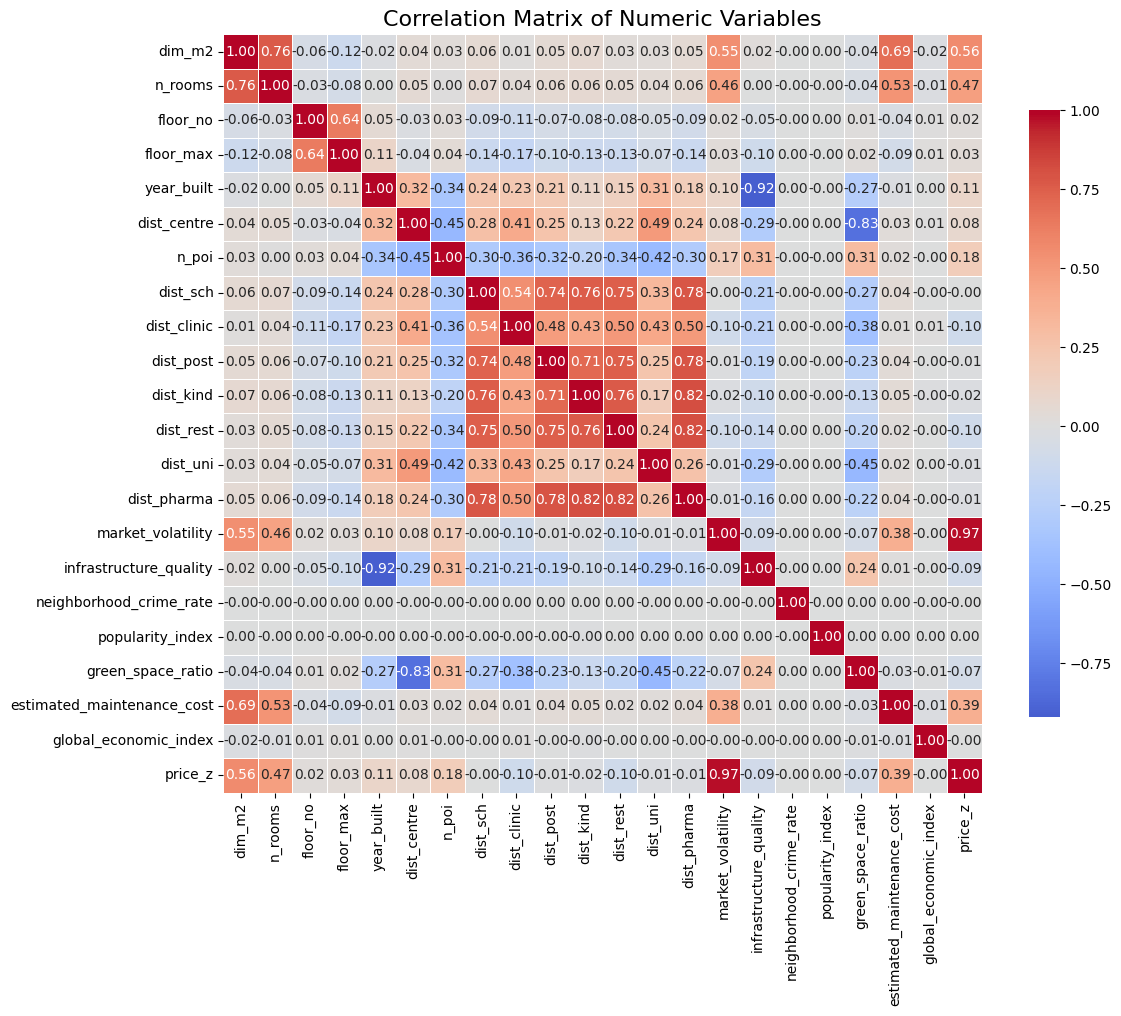

In [127]:
# Select numeric (non-indicator) columns
num_cols = aparts.select_dtypes(include=['int64', 'float64'])

# Compute Pearson correlation matrix
corr_matrix = num_cols.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Independent variables correlations
We can see that distance variables are strongly positively correlated. It shouldn't be a surprise, as cities in higly-developed countries offer more infrastructure in every neighberhood. Facilities such as pharmacies, restaurants, kindergardens, post and school are present nowadays in every part of urban areas. From the plots we can see that these relationships are linear. 
Outside the "red distance correlation triangle" on the matrix, we can also observe strong correlation between the size of the flat in squared meters and a couple of variables such as number of rooms, market volatility, estimated maintennce cost. 

As far as negative correlations are concerned, we can observe a big correlation between year of build and infrastructure qeuality. Similar for distance to the center and green-space ration varaibles. 

From the plots, we can see that many variables may have either linear or exponential decay relationships. For linear - especially the dist varaibles among themselfs. For exponential decay - floor number and floor max with most of the variables, , but also number of poi and distance variables and many more. The problem with exponnetial relationships is that it is not captured by pearson correaltion coefficient. Let's look at the correaltion matrix using Spearman correlation coefficient, which catches the non linear relationships

# Target varaible distribution

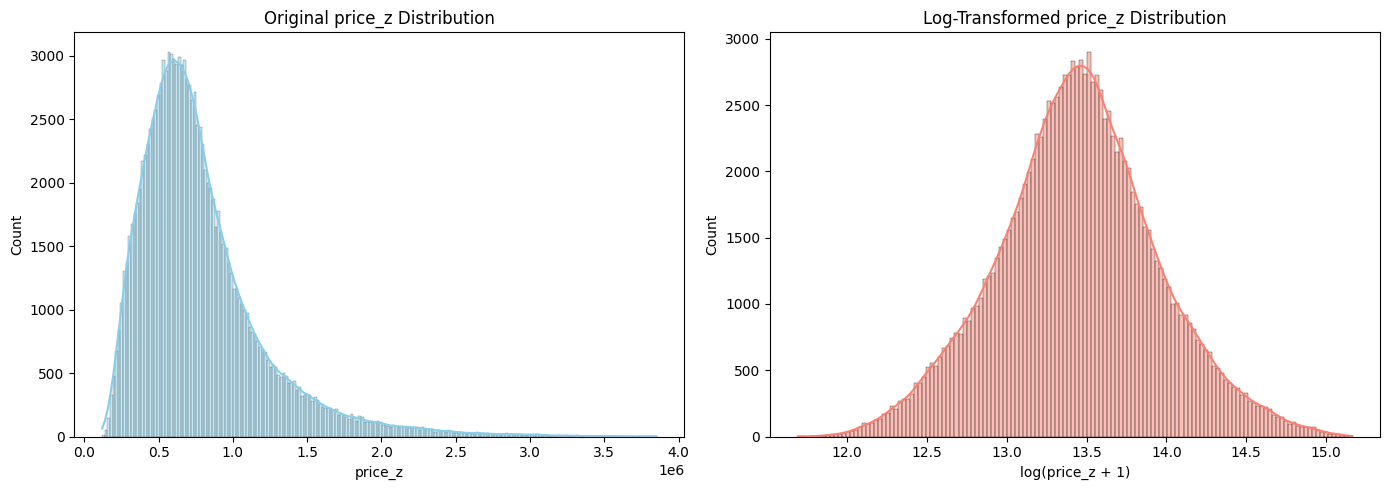

In [128]:
# We can see that the distribution of prices may be slightly righ skewed. LEts compare it with log version of the varaible

# Create a log-transformed version (add small constant to avoid log(0))
aparts['log_price_z'] = np.log1p(aparts['price_z'])

# Plot side-by-side distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(aparts['price_z'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original price_z Distribution')
axes[0].set_xlabel('price_z')

sns.histplot(aparts['log_price_z'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log-Transformed price_z Distribution')
axes[1].set_xlabel('log(price_z + 1)')

plt.tight_layout()
plt.show()

The log version of wages looks more similar to normal distribution. We will make it logged then

# Let's focus now on categorical variables

c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
c:\Users\grzes\AppData\Local\Programs\Python\Python313\

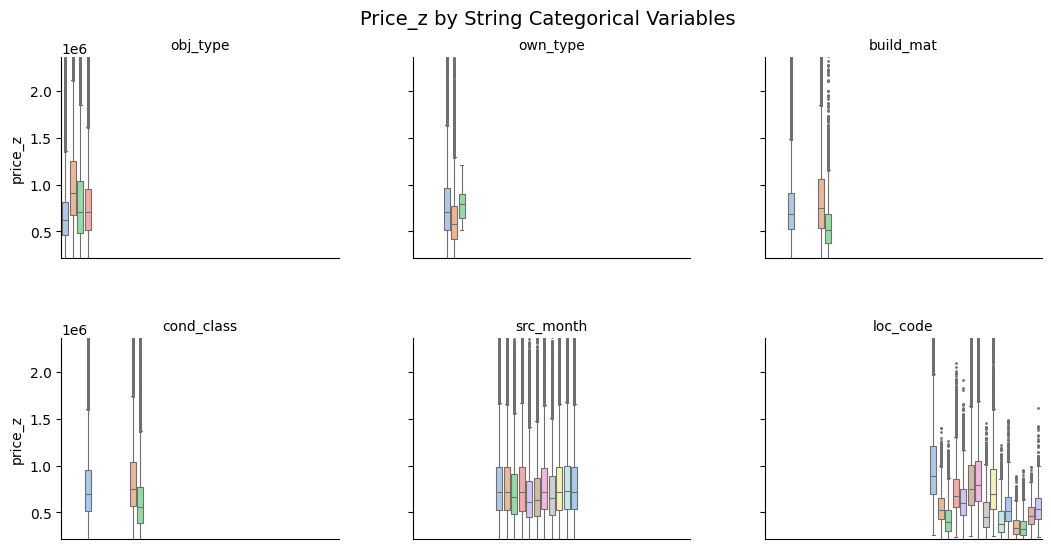

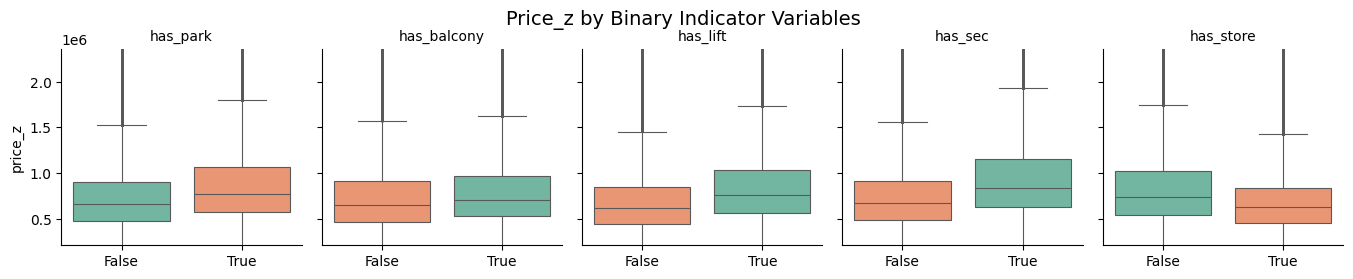

In [129]:
# MAde with AI help
# Define variables
string_cats = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'src_month', 'loc_code']
binary_flags = ['has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store']

# Prepare DataFrame
df = aparts[string_cats + binary_flags + ['price_z']].copy()
df[binary_flags] = df[binary_flags].astype(str)

# Clip y-axis
ymin, ymax = np.quantile(df['price_z'], [0.01, 0.99])

# 1. String categoricals (no x-tick labels)
melt_str = df.melt(id_vars='price_z', value_vars=string_cats,
                   var_name='variable', value_name='category')
g1 = sns.FacetGrid(melt_str, col='variable', col_wrap=3,
                   sharey=True, height=3, aspect=1.2)
g1.map_dataframe(sns.boxplot, x='category', y='price_z',
                 palette='pastel', fliersize=1, linewidth=0.8)
for ax in g1.axes.flatten():
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('')
    ax.set_xticks([])      # hide x-axis labels entirely
g1.set_titles("{col_name}")
g1.fig.subplots_adjust(top=0.9, hspace=0.4)
g1.fig.suptitle('Price_z by String Categorical Variables', fontsize=14)

# 2. Binary flags (with True/False ticks)
melt_bin = df.melt(id_vars='price_z', value_vars=binary_flags,
                   var_name='variable', value_name='category')
g2 = sns.FacetGrid(melt_bin, col='variable', col_wrap=5,
                   sharey=True, height=3, aspect=0.9)
g2.map_dataframe(sns.boxplot, x='category', y='price_z',
                 palette='Set2', fliersize=1, linewidth=0.8)
for ax in g2.axes.flatten():
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=0)
g2.set_titles("{col_name}")
g2.fig.subplots_adjust(top=0.85, hspace=0.3)
g2.fig.suptitle('Price_z by Binary Indicator Variables', fontsize=14)

plt.show()


We can see that for each varaible, the levels have many extreme/outlier price values above the interqueartile range. For instance, in the case of own_type, we can see one category having the highest median, but the two other categories have much more outliers at definitly higher levels of price_z, so the statistical significance prooving that the green category is associated with higher prices does not have to occur. Similar case for obj_type and build_mat.
Src_montth box plot does not highlight any categories with visibly higher prices, but variables cond_class and loc_code show clear leader.


In [130]:
# Let's try to find the statistical proove that the differences in prices in the context of cond_class and loc_code occur
selected_cats = ['cond_class', 'loc_code']
results = {}

# Loop through each variable and apply Kruskal-Wallis test
for var in selected_cats:
    groups = [group['price_z'].values for _, group in aparts.groupby(var)]
    if len(groups) > 1 and all(len(g) > 0 for g in groups):
        stat, p = kruskal(*groups)
        results[var] = {'H-statistic': stat, 'p-value': p, 'n_levels': len(groups)}

results

{'cond_class': {'H-statistic': np.float64(3269.8171759260076),
  'p-value': np.float64(0.0),
  'n_levels': 3},
 'loc_code': {'H-statistic': np.float64(48415.8354633447),
  'p-value': np.float64(0.0),
  'n_levels': 15}}

In [131]:
# Yes - the prices are different for different levels.

As far as dummy varaibles are concerned, here the differences seem to be more clear. Apartment with parking spot, balconny, lift in the building and security features are more expensive. However, the flats with storage rooms are less expensive than the ones not having it

# Feature engineering - Dealing with multicollinearity

## Dist varaibles (without dist centre)

We detected multicollinearity in distance variables. Let's solve this issue using Principal Component Analysis (PCA) technique for dimension reduction

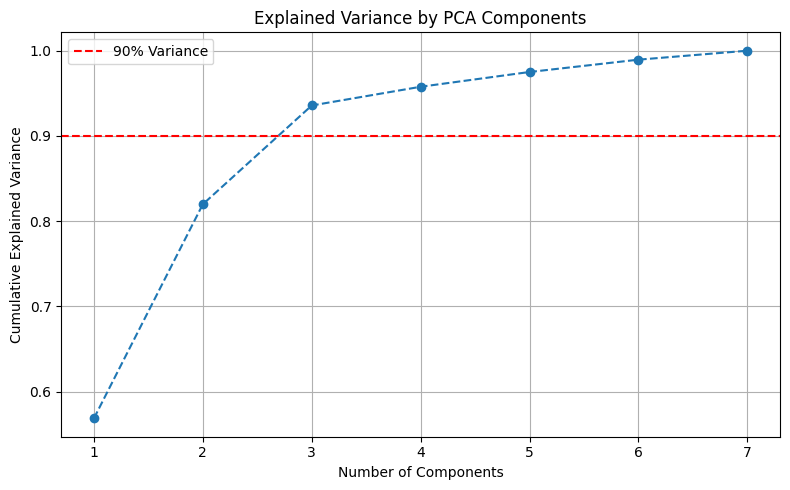

In [132]:
dist_vars = ['dist_sch', 'dist_clinic', 'dist_post',
             'dist_kind', 'dist_rest', 'dist_uni', 'dist_pharma']

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(aparts[dist_vars])

# Plot cumulative explained variance
cum_explained_var = pca_full.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [133]:
# 2 PCs explain more than 80% of variance. It's still not 90%, but dist varaibles have little influence on our target, so let's reduce the dimensionality to 2 PCs

# Fit and transform with optimal number of components
pca = PCA(n_components=2)  # Replace with your chosen number
X_pca = pca.fit_transform(aparts[dist_vars])

# Add principal components to the dataset
aparts['dist_pc1'] = X_pca[:, 0]
aparts['dist_pc2'] = X_pca[:, 1]

# Let's drop the dist variables
aparts = aparts.drop(columns= dist_vars)

Moreover, we have strong correlation between infrastructure_quality and year_built. Let's drop the one with fewer correlation with our target.

In [134]:
aparts = aparts.drop(columns='infrastructure_quality')

# Feature engineering - variables standarization and transformations

## DIST CENTRE

In [135]:
# Log transform 'dist_centre' (with handling for zero/negative values)
aparts['dist_centre_log'] = np.log(aparts['dist_centre'].replace(0, np.nan) + 1)  # Adding 1 to avoid log(0)

# Standardize it
scaler = StandardScaler()
aparts['dist_centre_log_scaled'] = scaler.fit_transform(aparts[['dist_centre_log']])

# Check the transformed dataset
print(aparts[['dist_centre', 'dist_centre_log', 'dist_centre_log_scaled']].head())

   dist_centre  dist_centre_log  dist_centre_log_scaled
0        5.507         1.872879                0.606415
1        3.971         1.603621                0.138718
2        3.908         1.590867                0.116563
3        4.831         1.763189                0.415885
4        1.077         0.730925               -1.377148


## Dim msquared 

In [136]:
# The distribution is slightly right skewed. Let's log-standarize the aparts['dim_m2']

# Step 1: Log-transform to reduce skewness
aparts['dim_m2_log'] = np.log1p(aparts['dim_m2'])  # log1p handles zero safely

# Step 2: Standardize the log-transformed variable
scaler = StandardScaler()
aparts['dim_m2_log_std'] = scaler.fit_transform(aparts[['dim_m2_log']])

# Let's drop the orginal dim_m2 variable
aparts = aparts.drop(columns='dim_m2')

## Numeric discrete variables

In [137]:
discrete_var = ['n_rooms', 'floor_no', 'floor_max', 'year_built']
for var in discrete_var:
    print(aparts[var].unique())

[3 2 1 5 4 6]
[ 7  2  4  3  6  5  1  8  9 14 10 15 11 17 12 13 16 22 21 20 23 29 18 24
 25 19 27]
[10  3  4 11  6  7  2 17  5 15 25  8 12  1 16 14 13 24 20 23  9 18 19 29
 26 27 22 28 21]
[1994 2024 1989 1974 1960 1980 2022 2020 1940 2021 1957 1976 1900 2017
 1961 2023 2019 2004 2015 1970 2016 2012 1996 2000 1982 1950 2018 1953
 1910 1972 2001 1983 1975 1934 2011 1997 1991 1890 1936 1978 1930 2002
 2010 1981 1973 1929 1977 2009 1979 1965 1955 2006 1906 1935 1968 1985
 1920 1958 2007 2013 1993 1963 1914 1905 1998 2008 1971 1999 1967 1915
 1964 1984 1928 1880 2003 1992 1990 1962 2005 1995 1907 1987 1947 1969
 1966 1931 2014 1956 1895 1986 1893 1937 1923 1938 1945 1939 1951 1952
 1912 1959 1896 1954 1988 1926 1902 1899 1927 1897 1901 1921 1908 1898
 1870 1913 1932 1904 1925 1911 1860 1948 1903 1882 1949 1922 1946 1933
 1909 1924 1891 1918 1942 1887 1894 1889 1876 1883 1875 1941 1886 1919
 1943 1885 1892 1944 1861 1851 1873 1916 1855 1878 1879 1850 1854 1852
 1865 1864 1888 1866 1872 1877 

In [138]:
# Let's create 'years_since_2000' for 'year_built'
aparts['years_since_2000'] = aparts['year_built'] - 2000

# Standardize 'years_since_2000'
scaler = StandardScaler()
aparts['years_since_2000_scaled'] = scaler.fit_transform(aparts[['years_since_2000']])

# Standardize other discrete numeric variables: 'n_rooms', 'floor_no', and 'floor_max'
aparts['n_rooms_scaled'] = scaler.fit_transform(aparts[['n_rooms']])
aparts['floor_no_scaled'] = scaler.fit_transform(aparts[['floor_no']])
aparts['floor_max_scaled'] = scaler.fit_transform(aparts[['floor_max']])

# remove the original columns after transformation:
aparts.drop(['year_built', 'n_rooms', 'floor_no', 'floor_max'], axis=1, inplace=True)

# Check the transformed dataset
print(aparts.head())


   obj_type  dist_centre  n_poi  own_type build_mat cond_class  has_park  \
0  0d6c4dfc        5.507     16  12631efb      NULL       NULL     False   
1  2a6d5c01        3.971     13  12631efb  7ceffe3b       NULL      True   
2  0d6c4dfc        3.908     21  bfb8fe10  7f8c00f9   a2881958     False   
3  0d6c4dfc        4.831      8  12631efb  7f8c00f9   53cced8d     False   
4  0d6c4dfc        1.077     48  12631efb  7ceffe3b       NULL      True   

   has_balcony  has_lift  has_sec  ...  dist_pc2 dist_centre_log  \
0         True      True     True  ...  0.628994        1.872879   
1         True      True    False  ...  0.556885        1.603621   
2         True     False    False  ... -0.079371        1.590867   
3        False      True    False  ...  0.123748        1.763189   
4         True     False    False  ... -0.319898        0.730925   

  dist_centre_log_scaled  dim_m2_log  dim_m2_log_std  years_since_2000  \
0               0.606415    4.219361        0.543569        

In [139]:
# Log transform 'n_poi' with log1p (log(1 + x) to handle zeros)
aparts['n_poi'] = np.log1p(aparts['n_poi'])

# Step 2: Standardize 'n_poi'
scaler = StandardScaler()
aparts['n_poi'] = scaler.fit_transform(aparts[['n_poi']])

## Remaining numeric variables

In [140]:
aparts[['market_volatility',
 'neighborhood_crime_rate', 'popularity_index',
       'green_space_ratio', 'estimated_maintenance_cost',
       'global_economic_index']].describe()

,market_volatility,neighborhood_crime_rate,popularity_index,green_space_ratio,estimated_maintenance_cost,global_economic_index
count,1.251630e+05,125163.000000,125163.000000,125163.000000,125163.000000,125163.000000
mean,7.839889e+05,49.832255,50.032838,0.999626,17.597423,99.656562
std,4.408828e+05,28.828346,10.036206,0.000488,10.070438,5.883064
min,1.012951e+05,0.000000,7.830000,0.998000,2.060000,89.913281
25%,4.926974e+05,24.910000,43.280000,0.999000,10.190000,93.794171
50%,6.849794e+05,49.760000,50.030000,1.000000,15.540000,100.357977
75%,9.503631e+05,74.830000,56.810000,1.000000,22.660000,105.230927
max,4.501184e+06,100.000000,95.360000,1.000000,87.200000,109.224165


In [141]:
aparts['green_space_ratio'].value_counts()

green_space_ratio
1.000    78687
0.999    46191
0.998      285
Name: count, dtype: int64

In [142]:
aparts = aparts.drop(columns='green_space_ratio')

In [143]:
# Apply log1p transformation to the specified variables
aparts['market_volatility'] = np.log1p(aparts['market_volatility'])
aparts['popularity_index'] = np.log1p(aparts['popularity_index'])
aparts['estimated_maintenance_cost'] = np.log1p(aparts['estimated_maintenance_cost'])

# Initialize StandardScaler
scaler = StandardScaler()

# Standardize the transformed variables
aparts[['market_volatility', 'popularity_index', 'estimated_maintenance_cost']] = \
    scaler.fit_transform(aparts[['market_volatility', 'popularity_index', 'estimated_maintenance_cost']])

# Check the transformed and standardized dataset
print(aparts[['market_volatility', 'popularity_index', 'estimated_maintenance_cost']].head())


   market_volatility  popularity_index  estimated_maintenance_cost
0           1.306043          1.104626                    0.417733
1           0.788064         -0.560459                   -0.112987
2          -0.943874          0.198800                   -1.254824
3          -1.348056          0.877658                    0.736278
4          -0.902553          0.643653                    0.290714


In [144]:
aparts.columns

Index(['obj_type', 'dist_centre', 'n_poi', 'own_type', 'build_mat',
       'cond_class', 'has_park', 'has_balcony', 'has_lift', 'has_sec',
       'has_store', 'src_month', 'loc_code', 'market_volatility',
       'neighborhood_crime_rate', 'popularity_index',
       'estimated_maintenance_cost', 'global_economic_index', 'price_z',
       'log_price_z', 'dist_pc1', 'dist_pc2', 'dist_centre_log',
       'dist_centre_log_scaled', 'dim_m2_log', 'dim_m2_log_std',
       'years_since_2000', 'years_since_2000_scaled', 'n_rooms_scaled',
       'floor_no_scaled', 'floor_max_scaled'],
      dtype='object')

## Binary

In [145]:
binary_flags = ['has_park', 'has_balcony', 'has_lift', 'has_sec',
       'has_store']
aparts[binary_flags]

,has_park,has_balcony,has_lift,has_sec,has_store
0,False,True,True,True,False
1,True,True,True,False,False
2,False,True,False,False,True
3,False,False,True,False,False
4,True,True,False,False,True
...,...,...,...,...,...
125158,True,False,False,True,True
125159,False,True,True,True,False
125160,False,True,False,False,True
125161,False,False,True,True,False


In [146]:
# Convert the boolean values to 0/1 using .astype(int)
aparts[binary_flags] = aparts[binary_flags].astype(int)

# Check the transformed dataset
print(aparts[binary_flags].head())


   has_park  has_balcony  has_lift  has_sec  has_store
0         0            1         1        1          0
1         1            1         1        0          0
2         0            1         0        0          1
3         0            0         1        0          0
4         1            1         0        0          1


## Categorical varaibles

In [147]:
string_cats = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'src_month', 'loc_code']
aparts[string_cats]

,obj_type,own_type,build_mat,cond_class,src_month,loc_code
0,0d6c4dfc,12631efb,NULL,NULL,2024-01-01,693f303c
1,2a6d5c01,12631efb,7ceffe3b,NULL,2024-06-01,693f303c
2,0d6c4dfc,bfb8fe10,7f8c00f9,a2881958,2023-11-01,3cb4aaff
3,0d6c4dfc,12631efb,7f8c00f9,53cced8d,2023-12-01,8d5a4f0c
4,0d6c4dfc,12631efb,7ceffe3b,NULL,2023-08-01,0ab06839
...,...,...,...,...,...,...
125158,0c238f18,bfb8fe10,7ceffe3b,NULL,2023-10-01,693f303c
125159,2a6d5c01,12631efb,7ceffe3b,NULL,2024-02-01,693f303c
125160,NULL,12631efb,NULL,NULL,2023-09-01,693f303c
125161,2a6d5c01,12631efb,7ceffe3b,NULL,2024-05-01,693f303c


In [148]:
for col in string_cats:
    print(aparts[col].value_counts())
    print('------------------------')

obj_type
0d6c4dfc    58673
NULL        26996
2a6d5c01    20662
0c238f18    18832
Name: count, dtype: int64
------------------------
own_type
12631efb    112691
bfb8fe10     12464
4e625087         8
Name: count, dtype: int64
------------------------
build_mat
7ceffe3b    58669
NULL        49661
7f8c00f9    16833
Name: count, dtype: int64
------------------------
cond_class
NULL        93599
a2881958    17840
53cced8d    13724
Name: count, dtype: int64
------------------------
src_month
2024-06-01    13768
2024-05-01    13034
2024-04-01    12344
2023-08-01    11949
2024-03-01    11105
2023-09-01    10837
2023-10-01    10790
2023-12-01    10562
2023-11-01    10492
2024-02-01    10389
2024-01-01     9893
Name: count, dtype: int64
------------------------
loc_code
693f303c    38086
378f340c    18523
0ab06839    12913
e0cff11b    12332
8d5a4f0c     9769
533f6886     6066
6900ba06     5259
a6d54bd1     4900
143768f7     4069
3cb4aaff     3660
ece39f3d     3360
765f79ed     1865
81b10147     1

In [149]:
# Extract month number from `src_month` and drop the original date column
aparts['src_monthn'] = pd.to_datetime(
    aparts['src_month'],
    format='%Y-%m-%d'
).dt.month
aparts.drop(columns=['src_month'], inplace=True)

# Let's list the categorical columns we will encode
cat_cols = ['obj_type', 'own_type', 'build_mat', 'cond_class', 'loc_code']

# Fit an OneHotEncoder (dropping the first level of each to avoid collinearity)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ohe.fit(aparts[cat_cols])

# Transform those columns into a dense array, build a DataFrame of dummy columns
dummy_array = ohe.transform(aparts[cat_cols]).toarray()
dummy_cols  = ohe.get_feature_names_out(cat_cols)
dummies_df  = pd.DataFrame(
    dummy_array,
    columns=dummy_cols,
    index=aparts.index
)

# Drop the raw categoricals from `aparts` and concatenate the new dummies
aparts.drop(columns=cat_cols, inplace=True)
aparts = pd.concat([aparts, dummies_df], axis=1)

# Let's inspect the result
print(aparts.head())
print("\nNew shape:", aparts.shape)


   dist_centre     n_poi  has_park  has_balcony  has_lift  has_sec  has_store  \
0        5.507  0.237205         0            1         1        1          0   
1        3.971  0.054076         1            1         1        0          0   
2        3.908  0.480390         0            1         0        0          1   
3        4.831 -0.362663         0            0         1        0          0   
4        1.077  1.235687         1            1         0        0          1   

   market_volatility  neighborhood_crime_rate  popularity_index  ...  \
0           1.306043                    43.37          1.104626  ...   
1           0.788064                    86.49         -0.560459  ...   
2          -0.943874                    93.77          0.198800  ...   
3          -1.348056                    11.95          0.877658  ...   
4          -0.902553                    62.56          0.643653  ...   

   loc_code_570cb745  loc_code_64a58667  loc_code_6900ba06  loc_code_693f303c  \

In [150]:
# Let's drop some columns we forget to drop above
aparts.drop(columns=[
    'dist_centre',
    'dist_centre_log',
    'years_since_2000',
    'dim_m2_log'
], inplace=True)

Global economic index

count    125163.000000
mean         99.656562
std           5.883064
min          89.913281
25%          93.794171
50%         100.357977
75%         105.230927
max         109.224165
Name: global_economic_index, dtype: float64


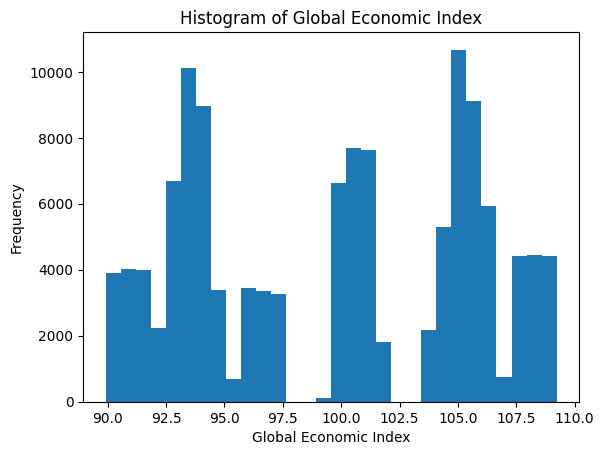

In [151]:
# 1) Check distribution of "global_economic_index"
print(aparts['global_economic_index'].describe())

# Let's plot a quick histogram
plt.figure()
plt.hist(aparts['global_economic_index'], bins=30)
plt.xlabel('Global Economic Index')
plt.ylabel('Frequency')
plt.title('Histogram of Global Economic Index')
plt.show()

As we can see, the distribution of this variable as a whole is far from being normal. However, we can distinguish here 3 groups of observations. LEt's tranform this variable to categorical form with 3 levels

In [152]:
# Define bins and labels
bins = [aparts['global_economic_index'].min() - 1, 96, 103, aparts['global_economic_index'].max()]
labels = ['Low', 'Medium', 'High']

# Create the ordinal categorical feature
aparts['global_economic_level'] = pd.cut(aparts['global_economic_index'], bins=bins, labels=labels, ordered=True)

# Drop the original column
aparts.drop(columns='global_economic_index', inplace=True)

In [153]:
print(aparts[['global_economic_level']].head())

  global_economic_level
0                   Low
1                  High
2                   Low
3                   Low
4                  High


In [154]:
# Convert global_economic_level to ordinal numeric with assigning

ordinal_map = {'Low': 0, 'Medium': 1, 'High': 2}
aparts['global_economic_level'] = aparts['global_economic_level'].map(ordinal_map)


In [155]:
# Apply one-hot encoding to `src_monthn`, drop the original
src_month_ohe = pd.get_dummies(aparts['src_monthn'], prefix='month', drop_first=True)

# Drop original month column and add encoded version
aparts.drop(columns='src_monthn', inplace=True)
aparts = pd.concat([aparts, src_month_ohe], axis=1)

# Return updated column summary
aparts.columns.tolist()


['n_poi',
 'has_park',
 'has_balcony',
 'has_lift',
 'has_sec',
 'has_store',
 'market_volatility',
 'neighborhood_crime_rate',
 'popularity_index',
 'estimated_maintenance_cost',
 'price_z',
 'log_price_z',
 'dist_pc1',
 'dist_pc2',
 'dist_centre_log_scaled',
 'dim_m2_log_std',
 'years_since_2000_scaled',
 'n_rooms_scaled',
 'floor_no_scaled',
 'floor_max_scaled',
 'obj_type_0d6c4dfc',
 'obj_type_2a6d5c01',
 'obj_type_NULL',
 'own_type_4e625087',
 'own_type_bfb8fe10',
 'build_mat_7f8c00f9',
 'build_mat_NULL',
 'cond_class_NULL',
 'cond_class_a2881958',
 'loc_code_143768f7',
 'loc_code_378f340c',
 'loc_code_3cb4aaff',
 'loc_code_533f6886',
 'loc_code_570cb745',
 'loc_code_64a58667',
 'loc_code_6900ba06',
 'loc_code_693f303c',
 'loc_code_765f79ed',
 'loc_code_81b10147',
 'loc_code_8d5a4f0c',
 'loc_code_a6d54bd1',
 'loc_code_e0cff11b',
 'loc_code_ece39f3d',
 'global_economic_level',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_8',
 'month_9',
 'month_10',
 'month_1

## Final steps of feature selection - Boruta and Lasso regularization

In [156]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [157]:
# Remove the target variables from the feature set
target_cols = ['price_z', 'log_price_z']
X = aparts.drop(columns=target_cols + ['Unnamed: 0'], errors='ignore')
y = aparts['log_price_z']  # Use log-transformed target

# Display feature and target shape
X.shape, y.shape

rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X.values, y.values)
selected = X.columns[boruta.support_]


In [158]:
# Confirmed relevant features
print("Selected features (Boruta):")
print(selected.tolist())

# Optional: check all feature rankings
feature_ranks = pd.DataFrame({
    'feature': X.columns,
    'rank': boruta.ranking_,
    'selected': boruta.support_
}).sort_values(by='rank')

print("\nTop-ranked features:")
print(feature_ranks.head(10))


Selected features (Boruta):
['market_volatility']

Top-ranked features:
                      feature  rank  selected
6           market_volatility     1      True
0                       n_poi     2     False
2                 has_balcony     2     False
1                    has_park     2     False
3                    has_lift     2     False
4                     has_sec     2     False
5                   has_store     2     False
7     neighborhood_crime_rate     2     False
8            popularity_index     2     False
9  estimated_maintenance_cost     2     False


We can see that only one feature - market_volatility - is the most relevant according to Boruta. Let's proceed further with feature selection using Lasso

In [159]:
# Drop target columns and index if it exists
target_cols = ['price_z', 'log_price_z']
X = aparts.drop(columns=target_cols + ['Unnamed: 0'], errors='ignore')
y = aparts['log_price_z']  # use log-transformed target

# Run LassoCV directly — no extra scaling
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X, y)

# Extract selected features
selected_lasso = X.columns[lasso.coef_ != 0].tolist()

# Output
print("Lasso-selected features:")
print(selected_lasso)


Lasso-selected features:
['n_poi', 'has_park', 'has_balcony', 'has_lift', 'has_sec', 'has_store', 'market_volatility', 'neighborhood_crime_rate', 'dist_pc1', 'dist_pc2', 'dist_centre_log_scaled', 'dim_m2_log_std', 'years_since_2000_scaled', 'n_rooms_scaled', 'floor_no_scaled', 'obj_type_0d6c4dfc', 'obj_type_2a6d5c01', 'own_type_bfb8fe10', 'build_mat_7f8c00f9', 'cond_class_NULL', 'cond_class_a2881958', 'loc_code_143768f7', 'loc_code_378f340c', 'loc_code_3cb4aaff', 'loc_code_533f6886', 'loc_code_6900ba06', 'loc_code_693f303c', 'loc_code_765f79ed', 'loc_code_81b10147', 'loc_code_8d5a4f0c', 'loc_code_e0cff11b', 'loc_code_ece39f3d', 'global_economic_level', 'month_4', 'month_5', 'month_6', 'month_8', 'month_9', 'month_10', 'month_11']


In [160]:
# In the output above, we can see the relevant featrures according to Lasso regularization. FRom the other hand, let's list the varaibles that were not listed above, so the possibly redundant features
redundant_features = [
    'estimated_maintenance_cost',   
    'popularity_index',              
    'obj_type_NULL',                 
    'own_type_4e625087',             
    'build_mat_NULL',                
    'floor_max_scaled',             
    'loc_code_570cb745',
    'loc_code_64a58667',
    'loc_code_a6d54bd1',            
    'month_2',
    'month_3',
    'month_12'                     
]

In [161]:
aparts_reduced = aparts.drop(columns=redundant_features)

# Let's save the results to csv

In [162]:
aparts_reduced.to_csv('Datasets/aparts_train_ready.csv')

In [163]:

# # Prepare data
# X_reduced = aparts_reduced.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_reduced = aparts_reduced['log_price_z']

# # Fit linear regression with 5-fold cross-validation
# lr = LinearRegression()
# cv_scores = cross_val_score(lr, X_reduced, y_reduced, cv=5, scoring='neg_root_mean_squared_error')

# # Report average RMSE across folds
# rmse_mean = -np.mean(cv_scores)
# rmse_mean


In [164]:


# aparts_test = pd.read_csv('aparts_test_2005.csv')

# # 1. Prepare training data
# X_train = aparts_reduced.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_train_log = aparts_reduced['log_price_z']

# # 2. Prepare test data
# X_test = aparts_test.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_test_log = aparts_test['log_price_z']
# y_test_price = aparts_test['price_z']

# # 3. Train final model on full training data
# lr = LinearRegression()
# lr.fit(X_train, y_train_log)

# # 4. Predict on test set
# y_pred_log = lr.predict(X_test)
# y_pred_price = np.expm1(y_pred_log)

# # 5. Evaluate
# rmse_log = root_mean_squared_error(y_test_log, y_pred_log)
# rmse_real = root_mean_squared_error(y_test_price, y_pred_price)

# # 6. Report results
# print("✅ Test RMSE (log scale):", round(rmse_log, 4))
# print("✅ Test RMSE (real price scale):", round(rmse_real, 2), "currency units")


Lasso regression

In [165]:

# # 1. Prepare training data
# X_train = aparts_reduced.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_train_log = aparts_reduced['log_price_z']

# # 2. Prepare test data
# X_test = aparts_test.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_test_log = aparts_test['log_price_z']
# y_test_price = aparts_test['price_z']

# # 3. Fit final Lasso model
# lasso = Lasso(alpha=0.001, max_iter=10000, random_state=42)
# lasso.fit(X_train, y_train_log)

# # 4. Predict
# y_pred_log_lasso = lasso.predict(X_test)
# y_pred_price_lasso = np.expm1(y_pred_log_lasso)

# # 5. Evaluate
# rmse_log_lasso = root_mean_squared_error(y_test_log, y_pred_log_lasso)
# rmse_real_lasso = root_mean_squared_error(y_test_price, y_pred_price_lasso)

# print("✅ Lasso Test RMSE (log scale):", round(rmse_log_lasso, 4))
# print("✅ Lasso Test RMSE (real price scale):", round(rmse_real_lasso, 2), "currency units")


In [166]:

# # 1. Prepare training data
# X_train = aparts_reduced.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_train_log = aparts_reduced['log_price_z']

# # 2. Prepare test data
# X_test = aparts_test.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_test_log = aparts_test['log_price_z']
# y_test_price = aparts_test['price_z']

# # 2. Tune alpha using LassoCV
# lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
# lasso_cv.fit(X_train, y_train_log)

# # 3. Use best alpha to fit final model (LassoCV already did this)
# best_alpha = lasso_cv.alpha_
# y_pred_log = lasso_cv.predict(X_test)
# y_pred_price = np.expm1(y_pred_log)

# # 4. Evaluate
# rmse_log = root_mean_squared_error(y_test_log, y_pred_log)
# rmse_real = root_mean_squared_error(y_test_price, y_pred_price)

# print(f"✅ Best alpha: {best_alpha}")
# print("✅ LassoCV Test RMSE (log scale):", round(rmse_log, 4))
# print("✅ LassoCV Test RMSE (real price scale):", round(rmse_real, 2), "currency units")


Random Forest

In [167]:

# # 1. Prepare training data
# X_train = aparts_reduced.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_train_log = aparts_reduced['log_price_z']

# # 2. Prepare test data
# X_test = aparts_test.drop(columns=['price_z', 'log_price_z'], errors='ignore')
# y_test_log = aparts_test['log_price_z']
# y_test_price = aparts_test['price_z']

# # 3. Train Random Forest Regressor (single-threaded to avoid system limits)
# rf = RandomForestRegressor(
#     n_estimators=100,       # Number of trees
#     max_depth=None,         # Let trees grow fully
#     random_state=42,        # Reproducibility
#     n_jobs=1                # Use 1 core (important for stability here)
# )
# rf.fit(X_train, y_train_log)

# # 4. Predict on test set
# y_pred_log = rf.predict(X_test)
# y_pred_price = np.expm1(y_pred_log)

# # 5. Evaluate performance
# rmse_log = root_mean_squared_error(y_test_log, y_pred_log)
# rmse_real = root_mean_squared_error(y_test_price, y_pred_price)

# # 6. Output results
# print("✅ Random Forest RMSE (log scale):", round(rmse_log, 4))
# print("✅ Random Forest RMSE (real price scale):", round(rmse_real, 2), "currency units")
